In [81]:
# Please do not change this cell because some hidden tests might depend on it.
import os

# Otter grader does not handle ! commands well, so we define and use our
# own function to execute shell commands.
def shell(commands, warn=True):
    """Executes the string `commands` as a sequence of shell commands.
     
       Prints the result to stdout and returns the exit status. 
       Provides a printed warning on non-zero exit status unless `warn` 
       flag is unset.
    """
    file = os.popen(commands)
    print (file.read().rstrip('\n'))
    exit_status = file.close()
    if warn and exit_status != None:
        print(f"Completed with errors. Exit status: {exit_status}\n")
    return exit_status

shell("""
ls requirements.txt >/dev/null 2>&1
if [ ! $? = 0 ]; then
 rm -rf .tmp
 git clone https://github.com/cs236299-2020/lab2-1.git .tmp
 mv .tmp/tests ./
 mv .tmp/requirements.txt ./
 rm -rf .tmp
fi
pip install -q -r requirements.txt
""")

In [82]:
# Initialize Otter
import otter
grader = otter.Notebook()

%%latex
\newcommand{\vect}[1]{\mathbf{#1}}
\newcommand{\cnt}[1]{\sharp(#1)}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\softmax}{\operatorname{softmax}}
\newcommand{\Prob}{\Pr}
\newcommand{\given}{\,|\,}

$$
\renewcommand{\vect}[1]{\mathbf{#1}}
\renewcommand{\cnt}[1]{\sharp(#1)}
\renewcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\renewcommand{\softmax}{\operatorname{softmax}}
\renewcommand{\Prob}{\Pr}
\renewcommand{\given}{\,|\,}
$$

# Course 236299
## Lab 2-1 – Language modeling with n-grams
We turn from tasks that _classify_ texts – mapping texts into a finite set of classes – to tasks that _model_ texts by providing a full probability distribution over texts (or providing a similar scoring metric). Such _language models_ attempt to answer the question "How likely is a token sequence to be generated as an instance of the language?".

We'll start with n-gram language models. Given a token sequence $x_1, x_2, \ldots, x_N$, its probability $\Prob(x_1, x_2, \ldots, x_N)$ can be calculated using the chain rule of probability:

$$\Prob(A, B \given \theta)= \Prob(A \given \theta) \cdot \Prob(B \given A, \theta) $$

Thus, 

\begin{align}
\Prob(x_1, x_2, \ldots, x_N) & = \Prob(x_1) \cdot \Prob(x_2, \ldots, x_N \given x_1) \\
& = \Prob(x_1) \cdot \Prob(x_2 \given x_1) \cdot \Prob(x_3, \ldots, x_N \given x_1, x_2) \\
& \cdots \\
& = \prod_{i=1}^N \Prob (x_i \given x_1, \cdots, x_{i-1}) \\
& \approx \prod_{i=1}^N \Prob (x_i \given x_{i-n+1}, \cdots, x_{i-1})\tag{1}
\end{align}

In the last step, we replace the probability $\Prob (x_i \given x_1, \cdots, x_{i-1})$, which conditions $x_i$ on _all_ of the preceding tokens, with $\Prob (x_i \given x_{i-n+1}, \cdots, x_{i-1})$, which conditions $x_i$ only on the $n-1$ preceding tokens. We call the $n-1$ preceding tokens ($x_{i-n+1}, \cdots, x_{i-1}$) the _context_ and $x_i$ the _target_. Taken together, these $n$ tokens form an $n$-gram, hence the term _$n$-gram model_.

In this lab you'll work with $n$-gram models: generating them, sampling from them, and scoring held-out texts according to them. We'll find some problems with $n$-gram models as language models:

1. They are profligate with memory.
2. They are sensitive to very limited context.
3. They don't generalize well across similar words.

In the next lab, we'll explore neural models to address these failings.

New bits of Python used for the first time in the _solution set_ for this lab, and which you may therefore find useful:

* [`itertools.product`](https://docs.python.org/3.8/library/itertools.html#itertools.product)
* [`random.random`](https://docs.python.org/3.8/library/random.html#random.random)

## Preparation – Loading packages and data

In [83]:
import itertools
import math
import random
import re
import torchtext as tt

from collections import defaultdict, Counter
from sys import getsizeof

# Set random seeds
SEED = 1234
random.seed(SEED)

In [84]:
# Some utilities to manipulate the corpus

def preprocess(text):
    """Strips #comments and empty lines from a string
    """
    result = []
    for line in text.split("\n"):
        line = line.strip()              # trim whitespace
        line = re.sub('#.*$', '', line)  # trim comments
        if line != '':                   # drop blank lines
            result.append(line)
    return result

def geah_tokenize(lines):
    """Specialized tokenizer for GEaH corpus handling speaker IDs"""
    result = []
    for line in lines:
        # tokenize
        tokens = tt.data.get_tokenizer("basic_english")(line)
        # revert the speaker ID token
        if tokens[0] == "sam":
            tokens[0] = "SAM:"
        elif tokens[0] == "guy":
            tokens[0] = "GUY:"
        else:
            raise ValueError("format problem - bad speaker ID")
        # add a start of sentence token
        result += ["<s>"] + tokens
    return result
                    
def postprocess(tokens):
    """Converts `tokens` to a string with one sentence per line"""
    return ' '.join(tokens)\
              .replace("<s> ", "\n")

# Read the GEaH data and preprocess into training and test streams of tokens
geah_filename = ("https://github.com/nlp-236299/data/raw/master/Seuss/"
                 "seuss - 1960 - green eggs and ham.txt")
shell(f'wget -nv -N -P data "{geah_filename}"')

def split(list, portions, offset):
    """Splits `list` into a "large" and a "small" part, returning them as a pair.
    
    The two parts are formed by partitioning `list` into `portions` disjoint pieces.
    The small part is the piece at index `offset`; the large part is the remainder.
    """
    return ([list[i] for i in range(0, len(list)) if i % portions != offset],
            [list[i] for i in range(0, len(list)) if i % portions == offset])

with open("data/seuss - 1960 - green eggs and ham.txt", 'r') as fin:
    lines = preprocess(fin.read())
    train_lines, test_lines = split(lines, 12, 0)
    train_tokens = geah_tokenize(train_lines)
    test_tokens = geah_tokenize(test_lines)

We've already loaded in the text of _Green Eggs and Ham_ for you and split it (about 90%/10%) into two token sequences, `train_tokens` and `test_tokens`. Here's a preview:

In [85]:
print(train_tokens[:50])
print(postprocess(train_tokens[:50]))

['<s>', 'SAM:', 'i', 'am', 'sam', '.', '<s>', 'SAM:', 'sam', 'i', 'am', '.', '<s>', 'GUY:', 'that', 'sam-i-am', '!', '<s>', 'GUY:', 'that', 'sam-i-am', '!', '<s>', 'GUY:', 'i', 'do', 'not', 'like', 'that', 'sam-i-am', '!', '<s>', 'SAM:', 'do', 'you', 'like', 'green', 'eggs', 'and', 'ham', '?', '<s>', 'GUY:', 'i', 'do', 'not', 'like', 'them', ',', 'sam-i-am']

SAM: i am sam . 
SAM: sam i am . 
GUY: that sam-i-am ! 
GUY: that sam-i-am ! 
GUY: i do not like that sam-i-am ! 
SAM: do you like green eggs and ham ? 
GUY: i do not like them , sam-i-am


In [86]:
print(test_tokens[:50])
print(postprocess(test_tokens[:50]))

['<s>', 'SAM:', 'i', 'am', 'sam', '.', '<s>', 'GUY:', 'i', 'do', 'not', 'like', 'green', 'eggs', 'and', 'ham', '.', '<s>', 'GUY:', 'not', 'in', 'a', 'box', '.', '<s>', 'SAM:', 'eat', 'them', '!', '<s>', 'GUY:', 'i', 'do', 'not', 'like', 'them', 'with', 'a', 'mouse', '.', '<s>', 'GUY:', 'not', 'in', 'a', 'car', '!', '<s>', 'SAM:', 'in']

SAM: i am sam . 
GUY: i do not like green eggs and ham . 
GUY: not in a box . 
SAM: eat them ! 
GUY: i do not like them with a mouse . 
GUY: not in a car ! 
SAM: in


We extract the vocabulary from the training text.

In [87]:
# Extract vocabulary from dataset
vocabulary = set(train_tokens)
print(vocabulary)

{'are', 'if', 'not', 'house', 'on', 'rain', '.', 'green', 'goat', 'try', 'car', 'sam', 'may', 'like', 'anywhere', 'that', 'train', 'eat', 'them', 'am', 'sam-i-am', 'boat', 'thank', '<s>', 'GUY:', 'they', 'SAM:', 'ham', 'a', 'be', 'with', 'let', 'good', 'say', 'will', 'would', 'i', 'there', 'do', 'box', 'mouse', 'see', 'you', 'tree', 'so', 'the', 'dark', 'could', 'in', 'fox', '!', 'me', '?', 'or', ',', 'here', 'and', 'eggs'}


## Generating $n$-grams

The _$n$-grams_ in a text are the contiguous subsequences of $n$ tokens. We will implement them as Python tuples. In theory, any sequence of $n$ tokens is a potential $n$-gram type. Let's generate a list of all the possible $n$-gram types over a vocabulary. Notice how the type/token distinction is useful for talking about $n$-grams, just as it is for words.
<!--
BEGIN QUESTION
name: all_ngrams
-->

In [88]:
#TODO
def all_ngrams(vocabulary, n):
    """Returns a list of all the possible `n`-long *tuples* of elements of the `vocabulary`,
    with repetitions, and order matters.
    
    For instance,  
        >>> all_ngrams(["one", "two"], 3)
        [('one', 'one', 'one'),
         ('one', 'one', 'two'),
         ('one', 'two', 'one'),
         ('one', 'two', 'two'),
         ('two', 'one', 'one'),
         ('two', 'one', 'two'),
         ('two', 'two', 'one'),
         ('two', 'two', 'two')]
         
    Order of returned list is not specified or guaranteed.
    When `n`=0, return [()].
    """
    if n == 0:
        return [()]
    
    return list(itertools.product(vocabulary, repeat=n))

all_ngrams(["one", "two"], 3)

[('one', 'one', 'one'),
 ('one', 'one', 'two'),
 ('one', 'two', 'one'),
 ('one', 'two', 'two'),
 ('two', 'one', 'one'),
 ('two', 'one', 'two'),
 ('two', 'two', 'one'),
 ('two', 'two', 'two')]

In [89]:
grader.check("all_ngrams")

All tests passed!

We can generate a list of all of the $n$-grams (tokens, not types) in a text.

In [90]:
def ngrams(tokens, n):
    """Returns a list of all `n`-grams in a list of `tokens`."""
    return [tuple(tokens[i : i + n])
            for i in range(0, len(tokens) - n + 1)]

In [91]:
print (train_tokens[:6])
print (ngrams(train_tokens[:6], 3))

['<s>', 'SAM:', 'i', 'am', 'sam', '.']
[('<s>', 'SAM:', 'i'), ('SAM:', 'i', 'am'), ('i', 'am', 'sam'), ('am', 'sam', '.')]


## Counting $n$-grams

We conceptualize an $n$-gram as having two parts:

* The _context_ is the first $n-1$ tokens in the $n$-gram.
* The _target_ is the final token in the $n$-gram.

An $n$-gram language model specifies a probability for each $n$-gram type. We'll implement a model as a 2-D dictionary, indexed first by context and then by target, providing the probability for the $n$-gram.

We start by generating a similar data structure for counting up the $n$-grams in a token sequence.

In [92]:
def ngram_counts(vocabulary, tokens, n):
    """Returns a dictionary of counts of the `n`-grams in `tokens`.
    
    The dictionary is structured with first index by (n-1)-gram context
    and second index by the final target token.
    """
    context_dict = defaultdict(lambda: defaultdict(int))
    # zero all ngrams
    for context in all_ngrams(vocabulary, n - 1):
        for target in vocabulary:
            context_dict[context][target] = 0
    # add counts for attested ngrams
    for ngram, count in Counter(ngrams(tokens, n)).items():
        context_dict[ngram[:-1]][ngram[-1]] = count
    return context_dict

Use the `ngram_counts` function to generate count data structures for unigrams, bigrams, and trigrams for the _Green Eggs and Ham_ training text.
<!--
BEGIN QUESTION
name: ngram_counts
-->

In [93]:
#TODO
unigram_counts = ngram_counts(vocabulary, train_tokens, 1)
bigram_counts = ngram_counts(vocabulary, train_tokens, 2)
trigram_counts = ngram_counts(vocabulary, train_tokens, 3)

In [94]:
grader.check("ngram_counts")

All tests passed!

Check your work by examining the total count of unigrams, bigrams, and trigrams. Do the numbers make sense?

In [118]:
# Calculate total counts of tokens, unigrams, bigrams, and trigrams
token_count = len(train_tokens)
unigram_count = sum(len(unigram_counts[cntxt]) for cntxt in unigram_counts)
bigram_count = sum(len(bigram_counts[cntxt]) for cntxt in bigram_counts)
trigram_count = sum(len(trigram_counts[cntxt]) for cntxt in trigram_counts)               

# Report on the totals
print(f"Tokens:   {token_count:6}\n"
      f"Unigrams: {unigram_count:6}\n"
      f"Bigrams:  {bigram_count:6}\n"
      f"Trigrams: {trigram_count:6}")

Tokens:     1147
Unigrams:     58
Bigrams:    3364
Trigrams: 195112


## Calculating $n$-gram probabilities

We can convert the counts into a probability model by _normalizing_ the counts. Given an $n$-gram type $x_1, x_2, \ldots, x_n$, instead of storing the count $\cnt{x_1, x_2, \ldots, x_n}$, we store an estimate of the probability 

\begin{align*}
  \Pr(x_n \given x_1, x_2, \ldots, x_{n-1})
  & \approx \frac{\cnt{x_1, x_2, \ldots, x_n}}{\cnt{x_1, x_2, \ldots, x_{n-1}}} \\
  & = \frac{\cnt{x_1, x_2, \ldots, x_n}}{\sum_{x'} \cnt{x_1, x_2, \ldots, x_{n-1}, x'}}
\end{align*}

that is, the ratio of the count of the $n$-gram and the sum of the counts of all $n$-grams with the same context. Fortunately, all of those counts are already stored in the count data structures we've already built. 

Write a function that takes an $n$-gram count data structure and returns an $n$-gram probability data structure. As with the counts, the probabilities should be stored indexed first by context and then by target.
<!--
BEGIN QUESTION
name: ngram_model
-->

In [119]:
def ngram_model(ngram_counts):
    """Returns an n-gram probability model calculated by normalizing the 
       provided `ngram-counts` dictionary
    """
    ngram_model = {}
    for context in ngram_counts:
      context_sum = sum([ngram_counts[context][target] for target in ngram_counts[context]])
      ngram_model[context] = {}
      for target, count in ngram_counts[context].items():
        if context_sum == 0:
          ngram_model[context][target] = 0
        else:
          ngram_model[context][target] = count / context_sum

    return ngram_model


In [120]:
grader.check("ngram_model")

All tests passed!

We can now build some $n$-gram models – unigram, bigram, and trigram – based on the counts.

In [121]:
unigram_model = ngram_model(unigram_counts)
bigram_model = ngram_model(bigram_counts)
trigram_model = ngram_model(trigram_counts)

## Space considerations

For the most part, we aren't too concerned in this course about matters of time or space efficiency, though these are crucial issues in the engineering of NLP systems. But the size of $n$-gram models merits consideration, looking especially at their size as $n$ grows. We can use Python's `sys.getsizeof` function to get a rough sense of the size of the models we've been working with.

In [99]:
print(f"Tokens:   {getsizeof(train_tokens):6}\n"
      f"Unigrams: {getsizeof(unigram_model):6}\n"
      f"Bigrams:  {getsizeof(bigram_model):6}\n"
      f"Trigrams: {getsizeof(trigram_model):6}")

Tokens:     9720
Unigrams:    240
Bigrams:    2280
Trigrams: 147560


<!-- BEGIN QUESTION -->

**Question:** What do these sizes tell you about the memory usage of $n$-gram models? With a larger vocabulary of, say, 10,000 words, would it be practical to run, say, 5-gram models on your laptop?
<!--
BEGIN QUESTION
name: open_response_sizes
manual: true
-->

The memory usage increases as the n in the n-grams rises. the size of the memory is a function of the vocabulary size to the power of n (each word in the vocabulary can appear in every part of an n-gram). Therefore, when we use a bigger vocabulary (such as one with 10,000 words, that compared to the 58 words in the training vocabulary is more than 170 times larger) and 5-gram - the memory usage is going to be huge ($10^{4 \cdot 5} = 10^{20}$) and not practical to run on a laptop.

<!-- END QUESTION -->



## Sampling from an $n$-gram model

We have cleverly constructed the models to index by context. This allows us to sample a word given its context. For instance, in the trigram context `("<s>", "SAM:")`, the following probability distribution captures which words can come next and with what probability:

In [100]:
trigram_model[("<s>", "SAM:")]

{'!': 0.0,
 ',': 0.0,
 '.': 0.0,
 '<s>': 0.0,
 '?': 0.0,
 'GUY:': 0.0,
 'SAM:': 0.0,
 'a': 0.11764705882352941,
 'am': 0.0,
 'and': 0.029411764705882353,
 'anywhere': 0.0,
 'are': 0.0,
 'be': 0.0,
 'boat': 0.0,
 'box': 0.0,
 'car': 0.0,
 'could': 0.08823529411764706,
 'dark': 0.0,
 'do': 0.029411764705882353,
 'eat': 0.029411764705882353,
 'eggs': 0.0,
 'fox': 0.0,
 'goat': 0.0,
 'good': 0.0,
 'green': 0.0,
 'ham': 0.0,
 'here': 0.058823529411764705,
 'house': 0.0,
 'i': 0.029411764705882353,
 'if': 0.0,
 'in': 0.029411764705882353,
 'let': 0.0,
 'like': 0.0,
 'may': 0.0,
 'me': 0.0,
 'mouse': 0.0,
 'not': 0.0,
 'on': 0.0,
 'or': 0.0,
 'rain': 0.0,
 'sam': 0.029411764705882353,
 'sam-i-am': 0.0,
 'say': 0.029411764705882353,
 'see': 0.0,
 'so': 0.029411764705882353,
 'thank': 0.0,
 'that': 0.0,
 'the': 0.0,
 'them': 0.0,
 'there': 0.0,
 'they': 0.0,
 'train': 0.0,
 'tree': 0.0,
 'try': 0.08823529411764706,
 'will': 0.0,
 'with': 0.0,
 'would': 0.2647058823529412,
 'you': 0.147058823529

We can sample a single token according to this probability distribution. Here's one way to do so.

In [101]:
def sample(model, context):
    """Returns a token sampled from the `model` assuming the `context`"""
    distribution = model[context]
    prob_remaining = random.random()
    for token, prob in sorted(distribution.items()):
        if prob_remaining < prob:
            return token
        else:
            prob_remaining -= prob
    raise ValueError

We can extend the sampling to a sequence of words by updating the context as we sample each word.

Define a function `sample_sequence` that performs this sampling of a sequence. It's given a model and a starting context and begins by sampling the first token based on the starting context, then updates the starting context to reflect the word just sampled, repeating the process until a specified number of tokens have been sampled.

<!--
BEGIN QUESTION
name: sample_sequence
-->

In [122]:
#TODO
def sample_sequence(model, start_context, count=100):
    """Returns a sequence of `count` tokens sampled successively
       from the `model` *following the `start_context`*.
       The length of the returned list should be `count+len(start_context)`.
    """
    random.seed(SEED) # for reproducibility, do not change
    final_seq = list(start_context)
    seq = list(start_context)
    sampled_count = 0
    for i in range(count):
        s = sample(model, tuple(seq))
        seq = (seq + [s])[1:]
        final_seq.append(s)
        sampled_count+=1
    return list(final_seq)

In [103]:
grader.check("sample_sequence")

All tests passed!

Let's try it.

In [104]:
print(postprocess(sample_sequence(unigram_model, ())))

would anywhere ! tree with i like . not 
, on SAM: i i 

. ! do would , fox could i . i GUY: ham in dark SAM: ? with boat eggs ! do ! 
could a , i 
ham 
with not would 
GUY: , GUY: sam-i-am 

would 
the , a SAM: GUY: say could not could say them anywhere not sam-i-am GUY: . 
and . eat thank do say in in SAM: like sam-i-am 
tree GUY: 
them not or are . a , GUY: ,


In [105]:
print(postprocess(sample_sequence(bigram_model, ("<s>",))))


SAM: sam ! 
SAM: try them , so good , will let me be ! 
GUY: and i would eat them here or there . 
GUY: i do not eat them anywhere . . 
GUY: i do not , sam-i-am ! 
GUY: that sam-i-am . 
GUY: and ham ? 
GUY: that sam-i-am . 
GUY: i do not in the dark . 
GUY: not like them , could not , sam-i-am . 
SAM: would you , sam-i-am . 
SAM: eat them on a train ! 
GUY: and ham !


In [106]:
print(postprocess(sample_sequence(trigram_model, ("<s>", "SAM:"))))


SAM: you may , i will not eat green eggs and ham ? 
GUY: i do not like green eggs and ham . 
GUY: i do not like them anywhere ! 
SAM: say ! 
GUY: and i will eat them in a house . 
GUY: that sam-i-am ! 
GUY: not in a tree ! 
GUY: i do not like them in a tree . 
GUY: not in a box . 
GUY: not in the dark . 
GUY: not in the dark ! 
SAM: would you , in a car !


## Evaluating text according to an $n$-gram model

### The probability metric

The main point of a language model is to assign probabilities (or similar scores) to texts. For $n$-gram models, that's done according to Equation (1) at the start of the lab. Let's implement that. We define a function `probability` that takes a token sequence and an $n$-gram model (and the $n$ of the model as well) and returns the probability of the token sequence  according to the model. It merely multiplies all of the $n$-gram probabilities for all of the $n$-grams in the token sequence.

> Throughout this lab, we ignore the scores of the first n-1 tokens as our n-gram model cannot score them due to the lack of context. In the next lab you will see how to solve this issue in practice.

In [107]:
def probability(tokens, model, n):
    """Returns the probability of a sequence of `tokens` according to an
       `n`-gram `model`
    """
    score = 1.0
    context = tokens[0:n-1]
    # Ignores the scores of the first n-1 tokens
    for token in tokens[n-1:]:
        prob = model[tuple(context)][token]
        score *= prob
        context = (context + [token])[1:]
    return score

We test it on the test text that we held out from the training text.

In [108]:
print(f"Test probability - unigram: {probability(test_tokens, unigram_model, 1):6e}\n"
      f"Test probability -  bigram: {probability(test_tokens, bigram_model, 2):6e}\n"
      f"Test probability - trigram: {probability(test_tokens, trigram_model, 3):6e}")

Test probability - unigram: 6.958063e-154
Test probability -  bigram: 7.888809e-44
Test probability - trigram: 0.000000e+00


### The negative log probability metric

Yikes, those probabilities are _really small_. Multiplying all those small numbers is likely to lead to underflow. 

To solve the underflow problem, we'll do our usual trick of using negative log probabilities 

$$ - \log_2 \left(\prod_{i=1}^N \Prob (x_i \given x_{i-n+1}, \cdots, x_{i-1})\right)$$

instead of probabilities.

Define a function `neglogprob` that takes a token sequence and an $n$-gram model (and the $n$ of the model as well) and returns the negative log probability of the token sequence according to the model, calculating it in such a way as to avoid underflow. (You'll want to simplify the formula above before implementing it.)

> Be careful when confronting zero probabilities. Taking `-math.log2(0)` raises a "Math domain error". Instead, you should use `math.inf` (Python's representation of infinity) as the value for the negative log of zero. This accords with our understanding that an impossible event would require infinite bits to specify.

<!--
BEGIN QUESTION
name: neglogprob
-->

In [109]:
#TODO
def neglogprob(tokens, model, n):
    """Returns the negative log probability of a sequence of `tokens`
       according to an `n`-gram `model`
    """
    score = 0.0
    context = tokens[0:n-1]
    # Ignores the scores of the first n-1 tokens
    for token in tokens[n-1:]:
        prob = model[tuple(context)][token]
        score += -math.log2(prob) if prob > 0 else math.inf
        context = (context + [token])[1:]
    return score

In [110]:
grader.check("neglogprob")

All tests passed!

We compute the negative log probabilities of the test text using the different models and report on them.

In [111]:
unigram_test_nlp = neglogprob(test_tokens, unigram_model, 1)
bigram_test_nlp = neglogprob(test_tokens, bigram_model, 2)
trigram_test_nlp = neglogprob(test_tokens, trigram_model, 3)

print(f"Test neglogprob - unigram: {unigram_test_nlp:6f}\n"
      f"Test neglogprob -  bigram: {bigram_test_nlp:6f}\n"
      f"Test neglogprob - trigram: {trigram_test_nlp:6f}")

Test neglogprob - unigram: 508.778241
Test neglogprob -  bigram: 143.185029
Test neglogprob - trigram:    inf


There, those numbers seem more manageable. We can even convert the neglogprobs back into probabilities as a sanity check.

In [112]:
print(f"Test probability - unigram: {2 ** (-unigram_test_nlp):6e}\n"
      f"Test probability -  bigram: {2 ** (-bigram_test_nlp):6e}\n"
      f"Test probability - trigram: {2 ** (-trigram_test_nlp):6e}")

Test probability - unigram: 6.958063e-154
Test probability -  bigram: 7.888809e-44
Test probability - trigram: 0.000000e+00


<!-- BEGIN QUESTION -->

**Question:** Why does the bigram model assign a lower neglogprob (that is, a higher probability) to the test text than the unigram model? Why does the trigram model assign a higher neglogprob (lower probability) to the test text than the other models?
<!--
BEGIN QUESTION
name: open_response_ordering
manual: true
-->

The unigram model gives each word a probability based on the number of its occurances, with no context at all. Thus words contribute a decrease in the probability by the factor of the word appearances divided by the total number of words. That mean the very rare words will make the whole probability low.

In the bigram model we count the occurences of a word after a context and divide by the context's number of occurences. In this calculation not all of the words are taken into account (as in the unigram), but only the words that appeared after the context. The probability of a rare word to be found after the context in the training (after more frequent word) is greater than it's probability to be found on it's own, it is observable from this formula:
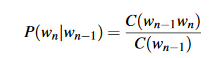

Thus, we expect that the rare words probabilities in some sense get smoother and normilized by the other words probabilities, which causes the whole probabilities to rise.

The trigram model gave zero probability to the test. That is a result of a context followed by a word that is being seen in the test but not in the training. Without smoothing such a case is given a probability of zero. Since we multiply probabilities - even one event where a sequence (context and word) is seen for the first time in the test, pushes the probability of the entire text to zero.

<!-- END QUESTION -->

### The perplexity metric

Another metric that is commonly used is _perplexity_. Jurafsky and Martin give a definition for perplexity as the "inverse probability of the test set normalized by the number of words":

$$ PP(x_1, x_2, \ldots, x_N) = 
     \sqrt[N]{\frac{1}{\prod_{i=1}^N \Prob (x_i \given x_{i-n+1}, \cdots, x_{i-1})}}
$$

Define a function `perplexity` that takes a token sequence and an $n$-gram model (and the $n$ of the model as well) and returns the perplexity of the token sequence according to the model, calculating it in such a way as to avoid underflow. (By now you're smart enough to realize that you'll want to carry out most of that calculation inside a $\log$.)

> Remember that we ignored the scores of the first n-1 tokens, what should the number of words `N` be?

<!--
BEGIN QUESTION
name: perplexity
-->

In [113]:
#TODO
def perplexity(tokens, model, n):
    """Returns the perplexity of a sequence of `tokens` according to an
       `n`-gram `model`
    """
    inversed_mult_probs = 2 ** neglogprob(tokens, model, n) # 2^{-Sigma_i(log(1/prob_i))} = P_i(1/prob_i)
    return inversed_mult_probs ** (1/(len(tokens)-(n-1)))

In [114]:
grader.check("perplexity")

All tests passed!

We can look at the perplexity of the test sample according to each of the models.

In [115]:
print(f"Test perplexity - unigram: {perplexity(test_tokens, unigram_model, 1):.3e}\n"
      f"Test perplexity -  bigram: {perplexity(test_tokens, bigram_model, 2):.3e}\n"
      f"Test perplexity - trigram: {perplexity(test_tokens, trigram_model, 3):.3e}")

Test perplexity - unigram: 3.174e+01
Test perplexity -  bigram: 2.672e+00
Test perplexity - trigram: inf


A perplexity value of $P$ can be interpreted as a measure of a model's average uncertainty in selecting each word equivalent to selecting among $P$ equiprobable words on average. The bigram model gives a perplexity of less than 3, indicating that at each word in the sentence, the model is acting as if selecting among (slightly less than) three equiprobable words.

For comparison, state of the art $n$-gram language models for more representative English text achieve perplexities of about 250.

<!-- BEGIN QUESTION -->

## Consensus section: Smoothing $n$-gram language models

> **This section is more open-ended in nature and need only be turned in for the consensus submission of the lab.**

The models we've been using have lots of zero-probability $n$-grams. Essentially any $n$-gram that doesn't appear on the training text is imputed a probability of zero, which means that any sentence that contains that $n$-gram will also be given a zero probability. Clearly this is not an accurate estimate.

There are many ways to _smooth_ $n$-gram models, just as you smoothed classification models in earlier labs. The simplest is probably add-$\delta$ smoothing. 

$$ \Prob(x_i \given x_1 \ldots x_{i-1})
  \approx \frac{\cnt{x_1, x_2, \ldots, x_n} + \delta}{\cnt{x_1, x_2, \ldots, x_{n-1}} + \delta \cdot |V|}
$$

Another useful method is to interpolate multiple $n$-gram models, for instance, estimating probabilities as an interpolation of trigram, bigram, and unigram models.

$$ \Prob(x_i \given x_1 \ldots x_{i-1}) \approx
     \lambda_2 \Prob(x_i \given x_{i-2}, x_{i-1}) 
     + \lambda_1 \Prob(x_i \given x_{i-1}) 
     + (1 - \lambda_1 - \lambda_2) \Prob(x_i)
$$

Finally, a method called _backoff_ uses higher-order $n$-gram probabilities where available, "backing off" to lower order where necessary.

$$
\Prob(x_i \given x_1 \ldots x_{i-1}) \approx \begin{cases}
    \Prob(x_i \given x_{i-2}, x_{i-1}) & \mbox{if $\Prob(x_i \given x_{i-2}, x_{i-1}) > 0$}\\
    \Prob(x_i \given x_{i-1})          & \mbox{if $\Prob(x_i \given x_{i-2}, x_{i-1}) = 0$ and $\Prob(x_i \given x_{i-1}) > 0$}\\
    \Prob(x_i)                         & \mbox{otherwise}
  \end{cases}
$$

Define a function `ngram_model_smoothed`, like the `ngram_model` function from above, but implementing one of these smoothing methods. Compare its perplexity on some sample text to the unsmoothed model. 

<!--
BEGIN QUESTION
name: open_response_smoothed_model
manual: true
-->

In [116]:
"""
#TODO
Place your definition of `ngram_model_smoothed` and whatever other testing 
of it you'd like to do in this and subsequent cells.
"""
def ngram_model_smoothed(ngram_counts):
    """Returns an n-gram probability model calculated by normalizing the 
       provided `ngram-counts` dictionary
    """
    ngram_model = {}
    for context in ngram_counts:
      context_sum = sum([ngram_counts[context][target] for target in ngram_counts[context]])
      ngram_model[context] = {}
      for target, count in ngram_counts[context].items():
        if context_sum == 0:
          ngram_model[context][target] = 0
        else:
          ngram_model[context][target] = (count+10) / (context_sum+10*len(vocabulary))

    return ngram_model

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Lab debrief – for consensus submission only

**Question:** We're interested in any thoughts your group has about this lab so that we can improve this lab for later years, and to inform later labs for this year. Please list any issues that arose or comments you have to improve the lab. Useful things to comment on include the following: 

* Was the lab too long or too short?
* Were the readings appropriate for the lab? 
* Was it clear (at least after you completed the lab) what the points of the exercises were? 
* Are there additions or changes you think would make the lab better?

<!--
BEGIN QUESTION
name: open_response_debrief
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



# End of Lab 2-1

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [117]:
grader.check_all()

all_ngrams:

    All tests passed!
    

neglogprob:

    All tests passed!
    

ngram_counts:

    All tests passed!
    

ngram_model:

    All tests passed!
    

perplexity:

    All tests passed!
    

sample_sequence:

    All tests passed!